In [13]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# NumPy is only used to load the .npz partially processed data file. It is later converted to pandas datasets
from numpy import load
import numpy

# load the dataset from its location in the Google Drive
data = load('/content/drive/MyDrive/Colab Notebooks/FacebookNetworkGCN/PatternFlow/recognition/FacebookNetworkGCN/facebook.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

edges
[[    0 18427]
 [18427     0]
 [    1 21708]
 ...
 [ 5563  5563]
 [22425 22425]
 [22425 22425]]
features
[[-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.36413375
  -0.12863389]
 [-0.26257643 -0.26505256 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 ...
 [-0.26257643 -0.27648264 -0.26235026 ... -0.18038896 -0.37209702
  -0.22261272]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.21814811]
 [-0.23227507 -0.27648264 -0.26235026 ... -0.19585785 -0.3759032
  -0.2212746 ]]
target
[0 2 1 ... 2 1 0]


In [15]:
# Load the necessary libraries. TensorFlow is the primary library used

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Initialise the data

In [16]:
# Load the edges as a pandas dataframe
edges = data["edges"]
edges = pd.DataFrame(data=edges, columns=["source", "target"])

print("Edges shape:", edges.shape)

Edges shape: (342004, 2)


In [17]:
edges.sample(frac=1).head()

,source,target
43010,1387,5622
270013,17722,6127
107423,21568,3816
173565,17780,6750
190604,7630,14585


In [18]:
# Load the pages as a pandas dataframe

id = numpy.arange(22470)
id = pd.DataFrame(data=id)

categories = data["target"]
categories = pd.DataFrame(data=categories)

pages = data["features"]
pages = pd.DataFrame(data=pages)

pages = numpy.concatenate((id, pages, categories), axis=1)

row_names = ["id"] + [f"term_{idx}" for idx in range(128)] + ["category"]
pages = pd.DataFrame(data=pages, columns=row_names)

print("Pages shape:", pages.shape)

Pages shape: (22470, 130)


In [19]:
print(pages.sample(5).T)

                 12354        1135         9904          19709        7294 
id        12354.000000  1135.000000  9904.000000  19709.000000  7294.000000
term_0       -0.262576    -0.262576    -0.262576     -0.262576    -0.262576
term_1       -0.276483    -0.276483    -0.276483      2.896598    -0.276483
term_2        3.388392    -0.261889    -0.262350     -0.262350    -0.262350
term_3        3.392747    -0.299327    -0.299327      3.383433    -0.299327
...                ...          ...          ...           ...          ...
term_124     -0.255755    -0.186689    -0.255755     -0.255755    -0.255755
term_125      4.812166    -0.215140    -0.215140     -0.215140    -0.215140
term_126     -0.375903    -0.368814    -0.375903     -0.375903    -0.375903
term_127     -0.223836    -0.214247    -0.223836     -0.080654    -0.217618
category      1.000000     3.000000     0.000000      0.000000     1.000000

[130 rows x 5 columns]


In [20]:
# Display a count of the number of pages in each category, 
# where the category is represented by a number from 0 to 3.
print(pages.category.value_counts())

2.0    6880
1.0    6495
3.0    5768
0.0    3327
Name: category, dtype: int64


In [31]:
# Convert the page id and edge into zero-based indices 

class_values = sorted(pages["category"].unique())

class_idx = {name: idx for idx, name in enumerate(class_values)}
pages["category"] = pages["category"].apply(lambda value: class_idx[value])

page_idx = {name: idy for idy, name in enumerate(sorted(pages["id"].unique()))}
pages["id"] = pages["id"].apply(lambda name: page_idx[name])
edges["source"] = edges["source"].apply(lambda name: page_idx[name])
edges["target"] = edges["target"].apply(lambda name: page_idx[name])

Visualise the graph

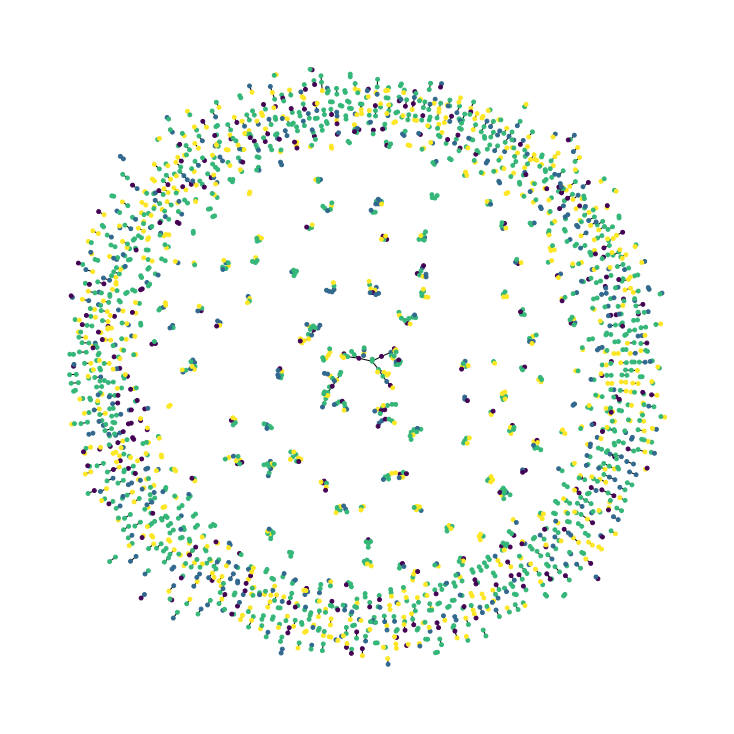

In [22]:
plt.figure(figsize=(10, 10))
colours = pages["category"].tolist()
fb_graph = nx.from_pandas_edgelist(edges.sample(n=1500))
page_type = list(pages[pages["id"].isin(list(fb_graph.nodes))]["category"])
nx.draw_spring(fb_graph, node_size=15, node_color=page_type)

In [23]:
# We split the data into test and train data sets, choosing about half of the
# dataset for training and half for testing
train_data, test_data = [], []

for _, grouped_data in pages.groupby("category"):
    train_data.append(grouped_data[:len(grouped_data.index)//2])
    test_data.append(grouped_data[len(grouped_data.index)//2:])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (11234, 130)
Test data shape: (11236, 130)


In [24]:
# Prepare the data for training the model

feature_names = set(pages.columns) - {"id", "category"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Convert test and train pandas datasets features to tensors.
x_train = tf.convert_to_tensor(train_data[feature_names])
x_test = tf.convert_to_tensor(test_data[feature_names])
# Convert test and train pandas datasets targets to tensors.
y_train = train_data["category"]
y_test = test_data["category"]

In [27]:
# Define constants
stopping_patience = 50
hidden_units = [128, 128]
learning_rate = 0.001
dropout_rate = 0.05
num_epochs = 300
batch_size = 512

In [25]:
# The train_model function compiles and trains the model using the x_train and y_train data
def train_model(model, x_train, y_train):
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    # Create an early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=stopping_patience, restore_best_weights=True
    )

    # Fit the model
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [26]:
# This function implents a feedforward network to be used in the GCN
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation='relu'))
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation='relu'))
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
        fnn_layers.append(layers.BatchNormalization())

    return keras.Sequential(fnn_layers, name=name)

In [28]:
# This function implements a baseline classifier
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create a FFN block
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

# Creates the baseline model
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 128)          103168      input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 128)          103168      ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 128)          0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [29]:
# Trains the baseline model
history = train_model(baseline_model, x_train, y_train)

Epoch 1/300
19/19 [==============================] - 17s 200ms/step - loss: 2.6976 - acc: 0.2900 - val_loss: 1.3637 - val_acc: 0.3215
Epoch 2/300
19/19 [==============================] - 2s 130ms/step - loss: 2.0426 - acc: 0.3291 - val_loss: 1.3806 - val_acc: 0.3185
Epoch 3/300
19/19 [==============================] - 3s 138ms/step - loss: 1.7866 - acc: 0.3526 - val_loss: 1.3553 - val_acc: 0.3399
Epoch 4/300
19/19 [==============================] - 3s 134ms/step - loss: 1.6179 - acc: 0.3731 - val_loss: 1.3293 - val_acc: 0.3826
Epoch 5/300
19/19 [==============================] - 3s 135ms/step - loss: 1.4985 - acc: 0.3981 - val_loss: 1.3161 - val_acc: 0.3796
Epoch 6/300
19/19 [==============================] - 3s 134ms/step - loss: 1.4093 - acc: 0.4282 - val_loss: 1.2765 - val_acc: 0.3956
Epoch 7/300
19/19 [==============================] - 2s 132ms/step - loss: 1.3387 - acc: 0.4402 - val_loss: 1.2356 - val_acc: 0.4448
Epoch 8/300
19/19 [==============================] - 2s 132ms/step -

In [30]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.59%
